# Multiresolution Decomp/Fourier Analysis comparison

## Fiber Optic Cable and Eddy-Covariance Observations

#### To Do
- Basic statistical comparison of EC $T_{air}$ observations and FOC DTS observations.
- Find segment of FOC vertical harp (Ultima) with the highest correlation with the ECObs (since we did not actually measure which bin is closest... whoops)
- Fourier analysis of FOC and ECObs
- Compare Fourier analysis to MRD
- Expand to include comparison with XT

In [4]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [5]:
# ------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/proj/VertHarpExp2017Kloendeel/'

dirPrint = dirPre + 'graphics'
dirProcessedEC = dirPre + 'data/land_station_eddycovar_2m_processed/'
dirProcessedUltima = dirPre + 'data/DTS_UltimaVHSRE_processed'

In [6]:
# ------------------------------------------------------------------------------------------
# Load processed 2m land station eddy covariance data
os.chdir(dirProcessedEC)
ecObs = xr.open_dataset('VHRSE.eddyCovarObs_2m_land.Raw.nc')

# ------------------------------------------------------------------------------------------
# Distributed temperature sensing observations
os.chdir(dirProcessedUltima)
ultima = xr.open_dataset('VHRSE_ultima_calibrated.nc')
ultima.attrs['locations'] = ultima.attrs['locations'].split(';')
ultima = xr.decode_cf(ultima)

# Initial plot of the data
plt.plot(ecObs.time, ecObs.S1_Ts)
plt.plot(ultima.time, ultima.swap_dims({'LAF': 'location'}).sel(location=''))

/anaconda/lib/python3.6/site-packages/xarray/conventions.py:838: UserWarning: CF decoding is overwriting dtype
  warnings.warn("CF decoding is overwriting dtype")


In [4]:
# There is an issue with the time stamps not behaving correctly when read from the netcdf files
ultimaTemp = ultima.manualTemp.resample(how='mean', freq='s', dim='time')
ecTemp = ecObs.Ts_mean.resample(how='mean', freq='s', dim='time')

/anaconda/lib/python3.6/site-packages/xarray/core/common.py:547: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


Object `examples` not found.


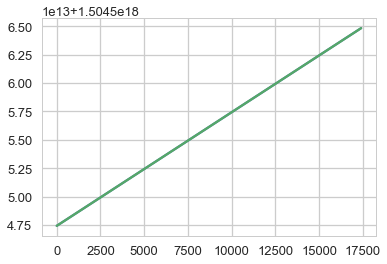

In [5]:
# # ------------------------------------------------------------------------------------------
# # Time stamps


Need to re-encode the datetime object in the netcdf. It is having problems. See previous working examples?

# Create a continuous time series for both datasets
d1 = pd.Timestamp(ultima.time[0].values)
d2 = pd.Timestamp(ultima.time[-1].values)
fullTime = pd.date_range(start=d1, end=d2, freq='1s')
ultima = ultima.reindex({'time': fullTime}, method='nearest', tolerance=timedelta(seconds=1))

# Align datasets
ecObs = ecObs.reindex_like(ultima.time, method='nearest', tolerance='1.5s', copy=True)

# Check time stamps
plt.figure()
plt.plot(ultima.time)
plt.plot(ecObs.time)


Need to re-encode the datetime object in the netcdf. It is having problems. See previous working examples

Text(0.5,1,'Vertical Harp Far')

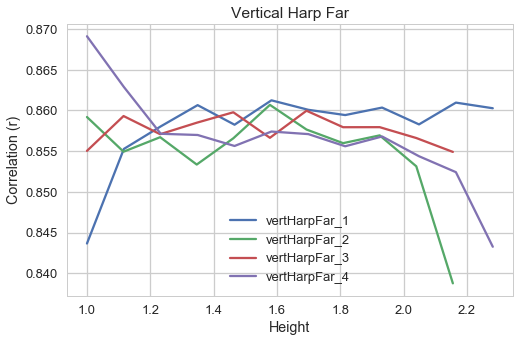

In [7]:
# ------------------------------------------------------------------------------------------
# Correlation between harp and EC
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
maxCorr = 0

for loc in ultima.locations:
    if 'vertHarpFar' in loc:
        segment = ultima.swap_dims({'LAF': 'location'}).sel(location=loc).swap_dims({'location': 'LAF'})
        corr = []
        for loc_LAF in segment.LAF:
            # Index nans
            nandex = np.flatnonzero(~np.isnan(segment.sel(LAF=loc_LAF).defaultTemp.values))
            r = scipy.stats.pearsonr(segment.sel(LAF=loc_LAF).defaultTemp[nandex], ecObs.Ts_mean[nandex])
            
            # Keep the best correlating segment
            if r[0] > maxCorr:
                maxCorr = r[0]
                segmentFar = segment.sel(LAF=loc_LAF)
            
            # Append to list
            corr.append(r[0])
        
        # Height variable to plot against
        vertHeight = np.arange(1, segment.LAF.max() - segment.LAF.min() + 1,
                               (segment.LAF.max() - segment.LAF.min()) / len(segment.LAF))
        ax.plot(vertHeight, corr, label=loc)

# Formatting
ax.legend()
ax.set_xlabel('Height')
ax.set_ylabel('Correlation (r)')
ax.set_title('Vertical Harp Far')

Text(0.5,1,'Vertical Harp Near')

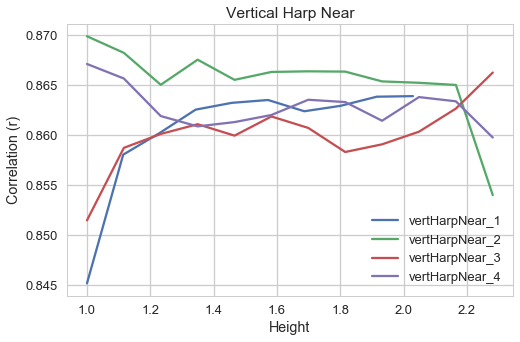

In [8]:
# ------------------------------------------------------------------------------------------
# Correlation between harp and EC
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
maxCorr = 0

for loc in ultima.locations:
    if 'vertHarpNear' in loc:
        segment = ultima.swap_dims({'LAF': 'location'}).sel(location=loc).swap_dims({'location': 'LAF'})
        corr = []
        for loc_LAF in segment.LAF:
            # Index nans
            nandex = np.flatnonzero(~np.isnan(segment.sel(LAF=loc_LAF).defaultTemp.values))
            r = scipy.stats.pearsonr(segment.sel(LAF=loc_LAF).defaultTemp[nandex], ecObs.Ts_mean[nandex])
            
            # Keep the best correlating segment
            if r[0] > maxCorr:
                maxCorr = r[0]
                segmentNear = segment.sel(LAF=loc_LAF)
            
            # Append to list
            corr.append(r[0])
        
        # Height variable to plot against
        vertHeight = np.arange(1, segment.LAF.max() - segment.LAF.min() + 1,
                               (segment.LAF.max() - segment.LAF.min()) / len(segment.LAF))
        ax.plot(vertHeight, corr, label=loc)

# Formatting
ax.legend()
ax.set_xlabel('Height')
ax.set_ylabel('Correlation (r)')
ax.set_title('Vertical Harp Near')

NameError: name 'segmentNear' is not defined

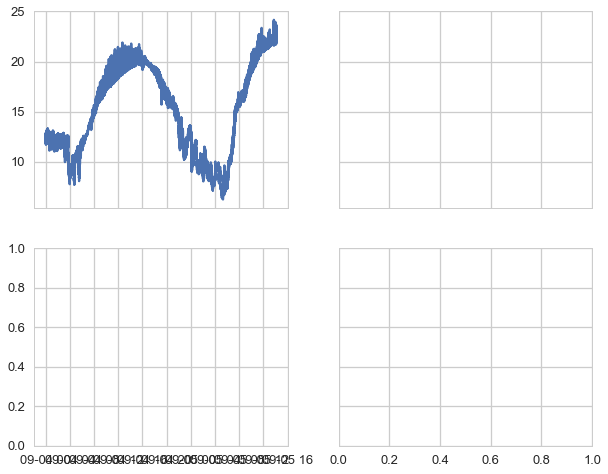

In [7]:
# Compare DTS to EC
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey='row', sharex='col')
axes = axes.flatten()

ax = axes[0]
ax.plot(ecObs.time.values, ecObs.Ts_mean)
ax.plot(segmentNear.time.values, segmentNear.manualTemp)
ax.set_ylabel('Air temperature ($^{\circ}$ C)')
ax.set_title('a) Manual Calibration (Near)')

ax = axes[1]
ax.plot(ecObs.time.values, ecObs.Ts_mean)
ax.plot(segmentNear.time.values, segmentNear.defaultTemp)
ax.set_title('b) Default Calibration (Near)')

ax = axes[2]
ax.plot(ecObs.time.values, ecObs.Ts_mean)
ax.plot(segmentFar.time.values, segmentFar.defaultTemp)
ax.set_ylabel('Air temperature ($^{\circ}$ C)')
ax.set_title('c) Manual Calibration (Far)')

ax = axes[3]
ax.plot(ecObs.time.values, ecObs.Ts_mean)
ax.plot(segmentFar.time.values, segmentFar.defaultTemp)
ax.set_title('d) Default Calibration (Far)')


### Best correlated section temperature with the EC data

## To do:
- Holy timestamp offset batman. Fix that. 
- Speaking of timestamps, why is matplotlib interpretting datetime64 objects incorrectly?

In [22]:
DTS = np.ma.masked_array(segmentNear.manualTemp, (np.isnan(segmentNear.manualTemp))
                         | (segmentNear.manualTemp > 100)
                         | (segmentNear.manualTemp < -30)).compressed()
sonic = np.ma.masked_array(ecObs.Ts_mean, (np.isnan(ecObs.Ts_mean))
                         | (ecObs.Ts_mean > 100)
                         | (ecObs.Ts_mean < -30)).compressed()

/anaconda/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/anaconda/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


# Fourier Analysis

In [ ]:
# # # Fourier analysis first

# # ###### NEED TO REMOVE/MASK NANS #######
# # from scipy.fftpack import fft

# dt_obs = 1 # [s]
# signal = ecObs.Ts_mean.values
# yf = fft(signal)
# xf = scipy.fftpack.fftfreq(len(signal)) * 1 / dt_obs

# plt.plot(1/xf[0:len(signal)//2], 2.0 / len(signal) * np.abs(yf[0:len(signal)//2]), '-o')
# plt.gca().set_xscale('log')

# # dt_obs = 1 # [s]
# # signal = DTS
# # yf = fft(signal)
# # xf = scipy.fftpack.fftfreq(len(signal)) * 1 / dt_obs

# # spectralPower = yf[0:len(signal)//2] ** 2 * dt_obs ** 2 / xf[0:len(signal)//2]

# # plt.plot(1/xf[0:len(signal)//2], 2.0 / len(signal) * np.abs(yf[0:len(signal)//2]), '-o')

# plt.plot(1/xf[0:len(signal)//2], spectralPower)
# plt.gca().set_xscale('log')
# plt.gca().set_xlim(0, 3600)
# plt.gca().set_ylim(0, 1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


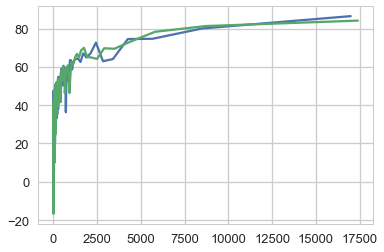

In [24]:
# Ok, so this seems like the most useful fft calculation.
from scipy.fftpack import fft

dt_obs = 1 # [s]
signal = DTS
p = 20*np.log10(np.abs(np.fft.rfft(signal)))
f = np.linspace(0, 1/2, len(p))
plt.plot(1/f, p)

signal = sonic
p = 20*np.log10(np.abs(np.fft.rfft(signal)))
f = np.linspace(0, 1/2, len(p))
plt.plot(1/f, p)

# Now need to redo this using just hour subsets and then composite together.

## Changes to the FFT spectral analysis

$ n \frac{\int{ww}}{\sigma^2_w} $ where $n$ is the natural frequency.  
- What is the natural frequency? The sampling frequency?

So in psuedo-code this would be.... ?
```
for n in scales:
   plot(n * sum(fft_values[0:n] ** 2) / sigma_values ** 2)
```

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


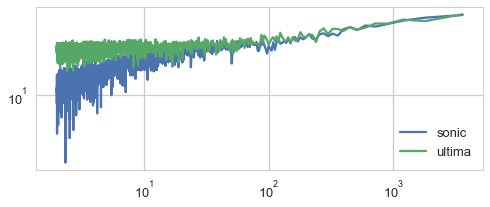

In [54]:
# Now to do the FFT using hour windows with a 6 minute overlap

dt_obs = 1 # [s]

# Hacky approach to indexing hour long windows with 6 minute overlap
numHours = np.floor(len(ecObs.time) / 3600)
tIndexBeg = np.arange(0, (numHours) * 3600, 3000)
tIndexEnd = tIndexBeg + 3600
if len(ecObs.time) < tIndexEnd[-1]:
    tIndexEnd = len(ecObs.time)

# EC
plt.subplots(1, 1, figsize=(8, 3))
p = np.zeros((int(3600 / 2 + 1), int(numHours + 1)))
for n, (beg, end) in enumerate(zip(tIndexBeg, tIndexEnd)):
    signal = sonic[np.arange(int(beg), int(end))]
    p[:, n] = 20*np.log10(np.abs(np.fft.rfft(signal)))
    f = np.linspace(0, dt_obs/2, len(p))
plt.plot(1/f, np.mean(p, 1), label='sonic')

# DTS
p = np.zeros((int(3600 / 2 + 1), int(numHours + 1)))
for n, (beg, end) in enumerate(zip(tIndexBeg, tIndexEnd)):
    signal = DTS[np.arange(int(beg), int(end))]
    p[:, n] = 20*np.log10(np.abs(np.fft.rfft(signal)))
    f = np.linspace(0, dt_obs/2, len(p))
plt.plot(1/f, np.mean(p, 1), label='ultima')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().legend()

## Multiresolution Decomposition

In [123]:
# ------------------------------------------------------------------------------------------
# 1-variable function. NOTE: It does not return power
def multires_1var(a, M):
    # Preallocate matrices
    avg = np.ones((M, 2**(M - 1)))
    for ims in np.arange(M, dtype='int'):
        ms = int(M - ims)
        l = int(2**ms)
        nw = int((2**M) / l)
        for i in np.arange(nw):
            k = i * l + 1
            # Assigns first value in i-th window
            za  = a[k]
            # Sums over the entire window length
            for j in np.arange(k, k + l):
                za = za + a[j]
            # Calculates avg over window
            za = za / l
            # Store avg
            avg[ims, i] = za
            # Removes window avg for next modes
            for j in np.arange(k, i * l):
                a[j] = a[j] - za 
    return(avg)

# ------------------------------------------------------------------------------------------
# 2-variable function. NOTE: It does return power
# Still needs further python conversion
def multires_2var(a, b, M): 
    # Preallocate matrices
    avg_a = np.ones((M + 1, 2**(M)))
    avg_b = np.ones((M + 1, 2**M))
    D = np.ones((M + 1))
    # Iterate through all modes. M + 1 because 2^11 = 2048, but python indexes from 0.
    for ims in np.arange(M + 1, dtype='int'):
        ms = M - ims 
        l = 2**ms
        nw = (2**M) / l
        sumab = 0
        for i in np.arange(nw, dtype='int'): 
            k = i * l + 1 
            # Assigns first value in i-th window
            za = a[k] 
            zb = b[k]
            # Sums over the entire window length
            for j in np.arange(k + 1, k + l - 1, dtype='int'):
                za = za + a[j]
                zb = zb + b[j]
            # Calculates avg over window
            za = za / l 
            zb = zb / l
            # Store avg
            avg_a[ims, i] = za
            avg_b[ims, i] = zb
            # Sums covariance due to window means
            sumab = sumab + za * zb
            # Removes window avg for next modes
            for j in np.arange(k, i * l, dtype='int'):
                a[j] = a[j] - za 
                b[j] = b[j] - zb
        if nw > 1:
            D[ms + 1] = sumab / nw 
    return(D, avg_a, avg_b)

signal = ecObs.Ts_mean.isel(time=np.arange(0, 3600))
D, avg_a, avg_b = multires_2var(signal, signal, 11)


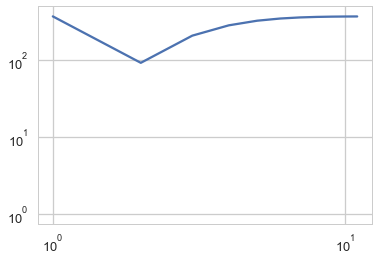

In [126]:
plt.plot(D)
plt.gca().set_xticks([1, 10, 60, 300, 1500])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [3]:
x = np.arange(0, 100, 0.1)
signal = np.sin(np.pi * x) + np.sin(np.)
a = DTS
b = DTS
totalModes = 3

# Preallocate matrices
avg_a = np.ones((totalModes + 1, 2**totalModes))
avg_b = np.ones((totalModes + 1, 2**totalModes))
D = np.ones((totalModes + 1))

for inverseModeNum in np.arange(totalModes + 1, dtype='int'):
    modeNum = totalModes - inverseModeNum
    # Length of the decomposition mode window
    windowLength = 2**modeNum
    # Number of the decomposition mode windown
    windowNum = (2**totalModes) / windowLength
    # Sum of the decomposition modes (for power spectrum)
    sumab = 0

    print('Mode Number: ' + str(modeNum))
    for windex in np.arange(windowNum, dtype='int'):
        print('Window index: ' + str(windex))
        # Window indices for summing
        startIndex = (windex * windowLength)
        endIndex = (windex * windowLength) + windowLength
        
        print(startIndex, endIndex)
        print(a[startIndex:endIndex])
        
        # Sums over the entire window length
        za = np.mean(a[startIndex:endIndex])
        zb = np.mean(b[startIndex:endIndex])
        
        # Store avg
        avg_a[inverseModeNum, windex] = za
        avg_b[inverseModeNum, windex] = zb
        
        # Sums covariance due to window means
        sumab = sumab + za * zb
        
        # Removes window avg for next modes
        a[startIndex:endIndex] = a[startIndex:endIndex] - za 
        b[startIndex:endIndex] = b[startIndex:endIndex] - zb

        print(za)
        plt.plot(avg_a[inverseModeNum])
        
    if windowNum > 1:
        D[inverseModeNum] = sumab / windowNum


SyntaxError: invalid syntax (<ipython-input-3-a0236cee3f16>, line 2)

In [138]:
a = DTS
print(a[0:8])

[ 15.98791868  16.10721229  16.49578778  16.55474738  16.55474738
  16.66033868  16.69362234  16.82763849]


In [94]:
plt.plot(D)
plt.gca().set_xticks([1, 10, 60, 300, 1500])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

[   1.           72.34158657   84.7405866   115.09995816]


In [ ]:
# Run MRD for DTS and sonic
numScales = 11
scales = 2**(np.arange(numScales))
tIndexBeg = np.arange(0, (numHours) * 3600, 3600)
spectraEC = np.zeros((numScales, len(tIndexBeg)))

for tNum, beg in enumerate(tIndexBeg):
    mrd_length = beg + 2 ** numScales
    end = int(beg + mrd_length) + 1
    if end > len(ecObs.time):
        end = len(ecObs.time)
    signal = ecObs.Ts_mean.isel(time=np.arange(int(beg), end))
    avg = multires_1var(signal, numScales)

    for n in np.arange(0, numScales):
        spectraEC[n, tNum] = np.nanstd(avg[n, 0:scales[n]] ** 2)


spectraDTS = np.zeros((numScales, len(tIndexBeg)))
for tNum, beg in enumerate(tIndexBeg):
    mrd_length = beg + 2 ** numScales
    end = int(beg + mrd_length) + 1
    if end > len(DTS):
        end = len(DTS)
    signal = DTS[int(beg): end]
    avg = multires_1var(signal, numScales)

    for n in np.arange(0, numScales):
        spectraDTS[n, tNum] = np.nanstd(avg[n, 0:scales[n]] ** 2)

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(0.077301918908278269, 1)

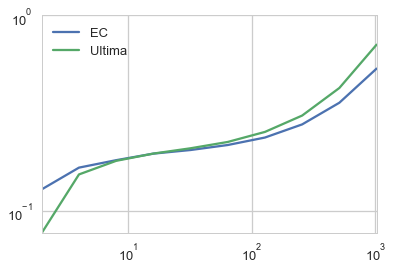

In [28]:
plt.subplots(1, 1)
plt.plot(scales, np.nanmean((spectraEC - spectraEC.min()) / (spectraEC.max() - spectraEC.min()), 1),
         label='EC')
plt.plot(scales, np.nanmean((spectraDTS - spectraDTS.min())  / (spectraDTS.max() - spectraDTS.min()), 1),
         label='Ultima')

# Format
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().legend()
# Remove first mode since it corresponds to a second
plt.gca().set_xlim(scales[1], scales[-1])
plt.gca().set_ylim(0, 1)

### MRD 
- Simply scaled the spectra to themselves.
- I am not convinced I am calculating the MRD correctly.
- Number of hours of data used: 5ish
- Data with a strong linear trend should have much more power at the longer frequencies, correct?